# Retail Sales EDA (Walmart-style)
Merges **sales + features + stores**, computes KPIs (year totals, per-store/department), holiday effects, markdown usage, and size relationships.


# Imports & display

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

pd.set_option("display.float_format", "{:,.2f}".format)
plt.rcParams["figure.figsize"] = (10,5)

SHOW_PLOTS = True     # show charts inline
SAVE_FIGS  = True     # also save charts to /charts

from pathlib import Path
CHARTS = Path("charts"); CHARTS.mkdir(exist_ok=True, parents=True)

def savefig(name: str):
    if SAVE_FIGS:
        plt.savefig(CHARTS / f"{name}.png", dpi=150, bbox_inches="tight")
    if not SHOW_PLOTS:
        plt.close()

# Load data

In [14]:
sales_path   = "data/sales data-set.csv"
feat_path    = "data/Features data set.csv"
stores_path  = "data/stores data-set.csv"

df_sales  = pd.read_csv(sales_path)
df_feat   = pd.read_csv(feat_path)
df_stores = pd.read_csv(stores_path)

display(df_sales.head(3)); display(df_feat.head(3)); display(df_stores.head(3))

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,"24,924.50",False
1,1,1,12/02/2010,"46,039.49",True
2,1,1,19/02/2010,"41,595.55",False


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,False
1,1,12/02/2010,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,True
2,1,19/02/2010,39.93,2.51,NaN,NaN,NaN,NaN,NaN,211.29,8.11,False


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392


# Merge & tidy

In [15]:
# Merge on Store, then on Store+Date (as in your script)
df = df_stores.merge(df_sales, on="Store").merge(df_feat, on=["Store","Date"])

# Date parts
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df["Year"] = df["Date"].dt.year

# Resolve duplicate holiday col names (…_x/_y) if present
if "IsHoliday_x" in df.columns and "IsHoliday_y" in df.columns:
    df = df.drop(columns=["IsHoliday_y"]).rename(columns={"IsHoliday_x":"IsHoliday"})

# Markdown total (MarkDown1..5 if present)
md_cols = [c for c in ["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"] if c in df.columns]
df[md_cols] = df[md_cols].fillna(0)
df["MarkdownTotal"] = df[md_cols].sum(axis=1)
df["HasMarkdown"] = df["MarkdownTotal"] > 0

df.head(3)

,Store,Type,Size,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,MarkdownTotal,HasMarkdown
0,1,A,151315,1,2010-02-05,"24,924.50",False,42.31,2.57,0.00,0.00,0.00,0.00,0.00,211.10,8.11,2010,0.00,False
1,1,A,151315,1,2010-02-12,"46,039.49",True,38.51,2.55,0.00,0.00,0.00,0.00,0.00,211.24,8.11,2010,0.00,False
2,1,A,151315,1,2010-02-19,"41,595.55",False,39.93,2.51,0.00,0.00,0.00,0.00,0.00,211.29,8.11,2010,0.00,False


# KPIs

In [16]:
# Total sales per year
total_sales_per_year = df.groupby("Year")["Weekly_Sales"].sum().sort_index()
display(total_sales_per_year)

# Average sales per store
avg_sales_per_store = df.groupby("Store")["Weekly_Sales"].mean().sort_values(ascending=False)
display(avg_sales_per_store.head(10))

# Total sales per department
total_sales_by_dept = df.groupby("Dept")["Weekly_Sales"].sum().sort_values(ascending=False)
display(total_sales_by_dept.head(10))


Year
2010   2,288,886,120.41
2011   2,448,200,007.35
2012   2,000,132,859.35
Name: Weekly_Sales, dtype: float64

Store
20   29,508.30
4    29,161.21
14   28,784.85
13   27,355.14
2    26,898.07
10   26,332.30
27   24,826.98
6    21,913.24
1    21,710.54
39   21,000.76
Name: Weekly_Sales, dtype: float64

Dept
92   483,943,341.87
95   449,320,162.52
38   393,118,136.92
72   305,725,152.21
90   291,068,463.68
40   288,936,022.05
2    280,611,174.43
91   216,781,705.73
13   197,321,569.95
8    194,280,780.73
Name: Weekly_Sales, dtype: float64

# Optional visuals

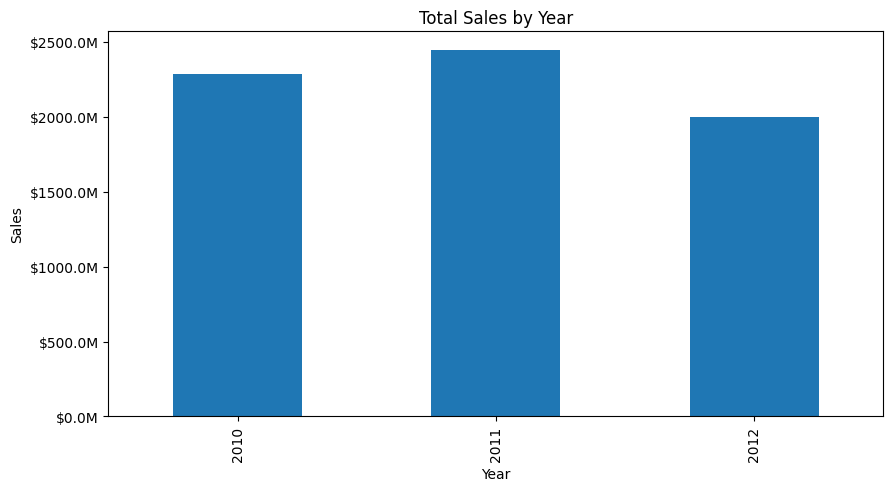

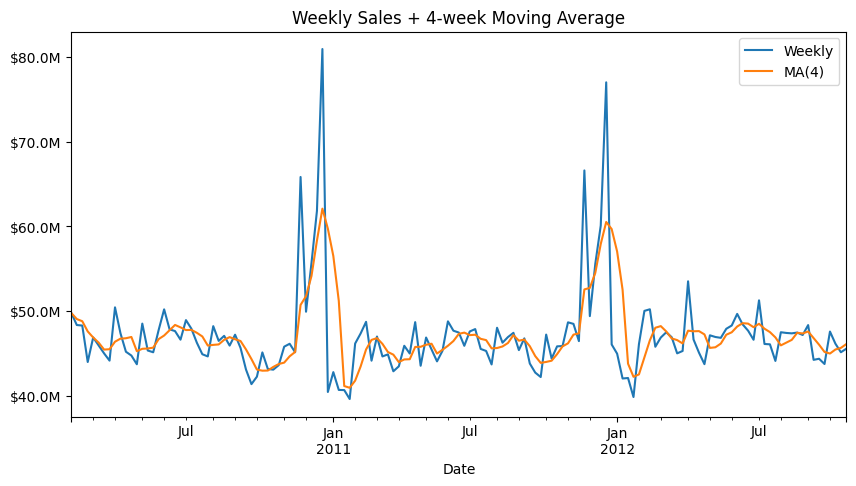

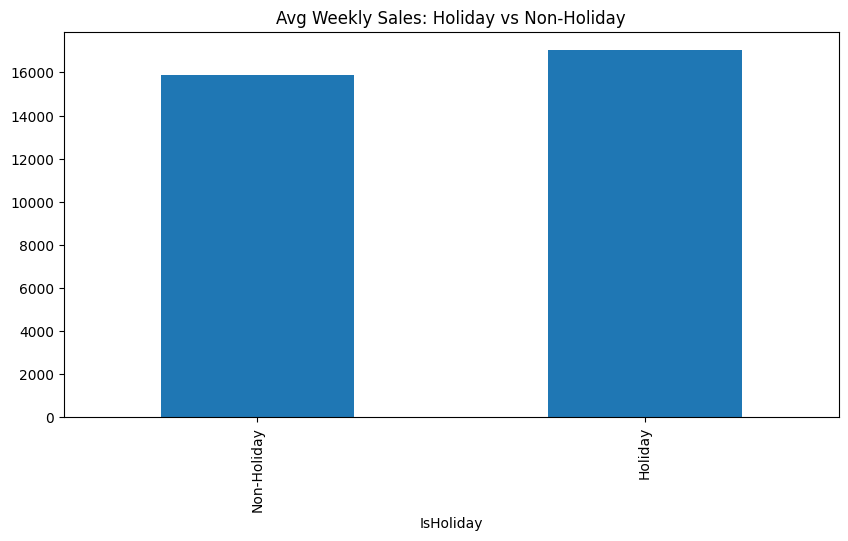

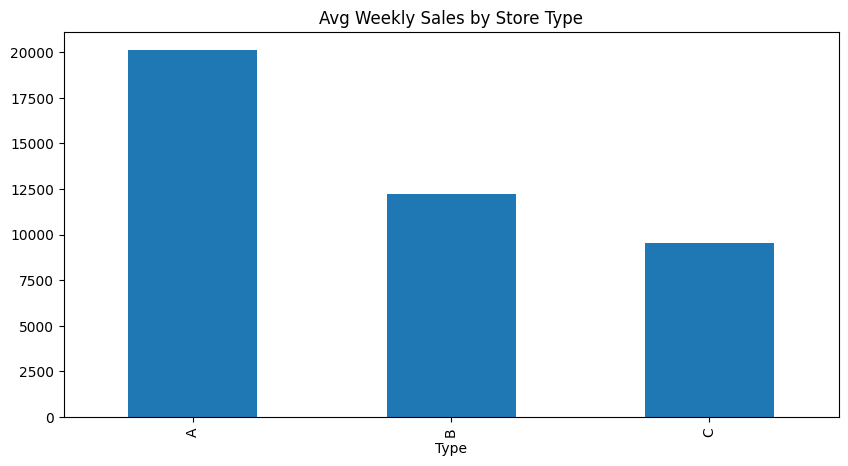

In [17]:
# Year totals
total_sales_per_year.plot(kind="bar")
plt.title("Total Sales by Year"); plt.ylabel("Sales")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x,_: f"${x/1e6:.1f}M"))
savefig("total_sales_by_year")
if SHOW_PLOTS: plt.show()

# Weekly total + 4-week MA
weekly = df.groupby("Date")["Weekly_Sales"].sum().sort_index()
weekly_ma4 = weekly.rolling(4, min_periods=1).mean()
weekly.plot(label="Weekly"); weekly_ma4.plot(label="MA(4)")
plt.legend(); plt.title("Weekly Sales + 4-week Moving Average")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x,_: f"${x/1e6:.1f}M")); 
savefig("weekly_sales_ma4")
if SHOW_PLOTS: plt.show()

# Holiday vs Non-Holiday (if IsHoliday exists)
if "IsHoliday" in df.columns:
    holiday_sales = df.groupby("IsHoliday")["Weekly_Sales"].mean()
    holiday_sales.index = holiday_sales.index.map({False:"Non-Holiday", True:"Holiday"})
    holiday_sales.plot(kind="bar"); plt.title("Avg Weekly Sales: Holiday vs Non-Holiday");
    savefig("avg_weekly_holiday_vs_non")
    if SHOW_PLOTS: plt.show()

# By Store Type (if present)
if "Type" in df.columns:
    df.groupby("Type")["Weekly_Sales"].mean().sort_values(ascending=False).plot(kind="bar")
    plt.title("Avg Weekly Sales by Store Type"); 
    savefig("avg_weekly_by_store_type")
    if SHOW_PLOTS: plt.show()


# Store-level relationships

,AvgWeeklySales,Size,Type
Store,,,
1,"21,710.54",151315,A
2,"26,898.07",202307,A
3,"6,373.03",37392,B
4,"29,161.21",205863,A
5,"5,053.42",34875,B


Corr(Size, AvgWeeklySales): 0.8072306200650589


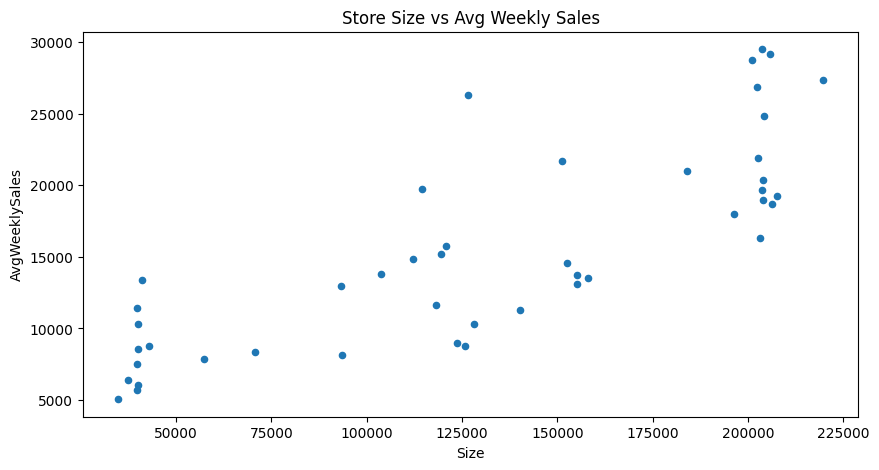

In [18]:
# Per-store summary: avg weekly sales, size, type
per_store = df.groupby("Store").agg(
    AvgWeeklySales=("Weekly_Sales","mean"),
    Size=("Size","first"),
    Type=("Type","first")
)
display(per_store.head())

# Size vs AvgWeeklySales correlation (print number; plot optional)
print("Corr(Size, AvgWeeklySales):", per_store["Size"].corr(per_store["AvgWeeklySales"]))
per_store.plot.scatter(x="Size", y="AvgWeeklySales", title="Store Size vs Avg Weekly Sales"); 
savefig("size_vs_avg_weekly_sales")
if SHOW_PLOTS: plt.show()


# Markdown analysis

,Store,WeeksWithMarkdown,TotalWeeks,PctWeeksMarkdown,Size,Type
0,1,3657,10244,35.70,151315,A
1,2,3663,10238,35.78,202307,A
2,3,3245,9036,35.91,37392,B
3,4,3676,10272,35.79,205863,A
4,5,3223,8999,35.82,34875,B
5,6,3652,10211,35.77,202505,A
6,7,3506,9762,35.91,70713,B
7,8,3535,9895,35.73,155078,A
8,9,3210,8867,36.20,125833,B
9,10,3646,10315,35.35,126512,B


Corr(Size, % Weeks Markdown): -0.5710988268936573


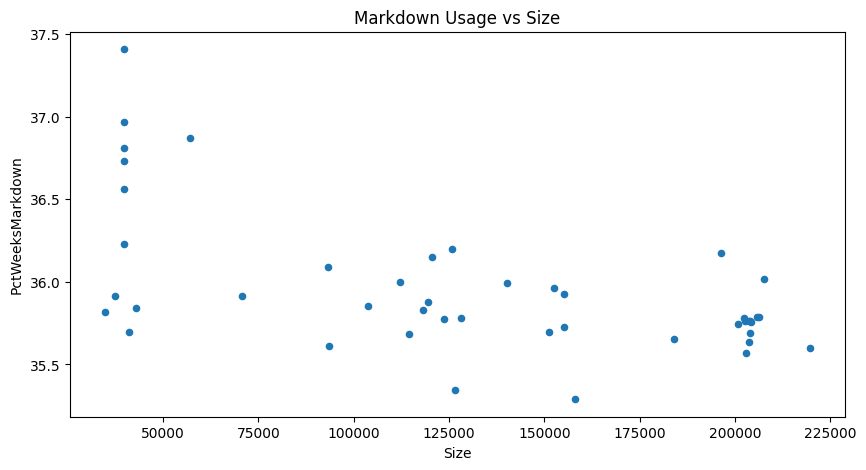

In [19]:
summary = df.groupby("Store").agg(
    WeeksWithMarkdown=("HasMarkdown","sum"),
    TotalWeeks=("HasMarkdown","count")
)
summary["PctWeeksMarkdown"] = 100 * summary["WeeksWithMarkdown"]/summary["TotalWeeks"]
summary = summary.merge(df_stores[["Store","Size","Type"]], on="Store", how="left")

display(summary.head(10))
print("Corr(Size, % Weeks Markdown):", summary["Size"].corr(summary["PctWeeksMarkdown"]))
summary.plot.scatter(x="Size", y="PctWeeksMarkdown", title="Markdown Usage vs Size"); 
savefig("size_vs_pct_weeks_markdown")
if SHOW_PLOTS: plt.show()


# Save key outputs

In [20]:
from pathlib import Path
Path("outputs").mkdir(exist_ok=True)
total_sales_per_year.to_csv("outputs/total_sales_per_year.csv")
avg_sales_per_store.to_csv("outputs/avg_sales_per_store.csv")
total_sales_by_dept.to_csv("outputs/total_sales_by_dept.csv")
summary.to_csv("outputs/markdown_summary_by_store.csv")
print("Saved CSVs to outputs/")


Saved CSVs to outputs/
